<a href="https://colab.research.google.com/github/yonilev2003/EDA-Music-Recommendation-System/blob/main/Music_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The Spotify Dataset contains about 170,000 songs, going back as far as the 1920s and up to 2020. I used this vast dataset aiming for 2 goals:
1. Understanding how music has evolved in the last 100 years.
2. Crafting a content-based recommendation system to make song recommendations.

# Importing & Installments

In [ ]:
# Installing Kaggle API
! pip install kaggle

In [ ]:
# Installing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
from scipy.stats import linregress
import warnings
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Setting Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'yonathanlevy'
os.environ['KAGGLE_KEY'] = 'd161e19bbcf37f55b9e5a0d6e5497e55'

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d vatsalmavani/spotify-dataset

# Unzip the dataset
!unzip -o spotify-dataset.zip

500 - Internal Server Error
Archive:  spotify-dataset.zip
  inflating: data/data.csv           
  inflating: data/data_by_artist.csv  
  inflating: data/data_by_genres.csv  
  inflating: data/data_by_year.csv   
  inflating: data/data_w_genres.csv  


In [ ]:
# Loading the datasets
data = pd.read_csv('data/data.csv')

# Cleaning

To clean the dataset, I removed duplicates, checked for missing values and the data types.

I think that 'release_date' and 'year' both indicate other forms of the same data, though I needed to check that with 100% certainty. First, I both converted 'release_date' to be the same data type as 'year' (which is int64), and extracted the year. Then, I could compare similarity, which is 100%. So I dropped the 'release_date' column.

In [ ]:
# Looking at the first 5 rows
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [ ]:
# Removing duplicates
data = data.drop_duplicates()

# Checking for missing values and data types
data.isnull().sum(), data.dtypes

(valence             0
 year                0
 acousticness        0
 artists             0
 danceability        0
 duration_ms         0
 energy              0
 explicit            0
 id                  0
 instrumentalness    0
 key                 0
 liveness            0
 loudness            0
 mode                0
 name                0
 popularity          0
 release_date        0
 speechiness         0
 tempo               0
 dtype: int64,
 valence             float64
 year                  int64
 acousticness        float64
 artists              object
 danceability        float64
 duration_ms           int64
 energy              float64
 explicit              int64
 id                   object
 instrumentalness    float64
 key                   int64
 liveness            float64
 loudness            float64
 mode                  int64
 name                 object
 popularity            int64
 release_date         object
 speechiness         float64
 tempo               float

In [ ]:
# Checking whether 'Release_Date' and 'Year' hold the same values
# Extracting year from 'Release_Date' and converting to int64
data['release_date'] = pd.to_datetime(data['release_date']).dt.year.astype('int64')

# Checking the similarity in values
similarity_percentage = (data['release_date'] == data['year']).mean() * 100
print(similarity_percentage)

# Dropping 'Release_Year'
data.drop(columns=['release_date'], inplace=True)

100.0


# EDA

First, I visualized the numerical columns and drew some insights:

1. Valence - a fairly even distribution with a slight preference for higher valence, suggesting there's a variety of music catering to different emotional states. It's greatly benefitial for a recommendation system.
2. Year - the dataset contains music from a broad range of time periods, potentially enablling the recommendation system to cater to fans of both modern and older music.
3. Acousticness - the distribution is bimodal, indicating two distinct groups of tracks - one is highly acoustic and one that is not. It could be useful for creating recommmendations based on whether a user prefers acoustic or more electronic music.
4. Danceability - the skew towards higher values suggesting the dataset including many tracks suitable for dancing, which could inform recommendations for playlists meant for parties or workouts.
5. Duration - a wider range would insist the recommendation system to put an emphasis on whether the user prefers longer or shorter songs.
6. Energy - a skew towards higher energy tracks, suggesting the music is more upbeat.
7. Explicit - most music doesn't seem to show explicit content.
8. Instrumentalness - The dataset seems to include a significant amount of non-instrumental tracks, but with a long tail that suggests a presence of instrumental music as well, which can be good for focus or relaxation-based playlists.
9. Key - Distribution across different musical keys indicates a variety of harmonies and can be a subtle factor in user preferences for music.
10. Liveness - this feature's distribution could inform whether a user gets recommended more studio-produced music versus live recordings.
11. Loudness - a leaning towards louder tracks could reflect modern mastering trends or a preference in user listening.
12. Mode - the distribution between major and minor modes can affect the emotional tone of the music, with major often perceived as happier and minor as more somber.
13. Popularity - with many tracks on the lower end of popularity, the recommendation system has the opportunity to introduce users to lesser-known music.
14. Spechiness - Most tracks are likely to be music rather than spoken word, which is typical, but there may be some content like rap where speechiness is higher.
15. Tempo - a broad range of tempos means many musical styles and user activity levels, from relaxed to active.

I wanted to understand what are the most popular songs, who are the most popular artists and which artists are the most popular by the decade.

I didn't know most artists, indicating that a musician with high popularity scores might be relatively unkown, but a relatively known musician might recieve lower popularity scores. So, I prompted a list of 22 musicians I like that I'm sure to have a representation in the dataset. To my surprise, none of them recieved a high popularity score.

At last, before creating a recommendation system, I wanted to understand some music trends over time. I used linear regression to understand trends in the following features:
1. Danceability - do songs become more dancable over time?
2. Duration - does songs become shorter/longer over time?
3. Keys - does songs use more diversed keys, or rather become more concentrated around the same set of keys?
4. Liveness - does songs recieve higher or lower liveness scores over time?
5. Speechiness - do songs use less speech than before?
6. Tempo - do songs have higher tempo over time?
7. Loudness - do songs become more loud over time?

Even though the answers to some questions (like tempo) might be obvious, I wanted a mathematical proof for that.
Looking at the output, I understood some major trends in nowadays music compared to older music:
1. Songs are more danceable, energetic, louder and with higher tempo.
2. Songs are longer in time, yet with decline in speechiness.
3. Songs decline in liveness, suggesting fewer live recordings or less lvie-sounding production.
4. Key diversity with no significant trend, suggesting an unclear trend towards either more diversity or more concentration in keys used in songs, with a p-value of 1.0.

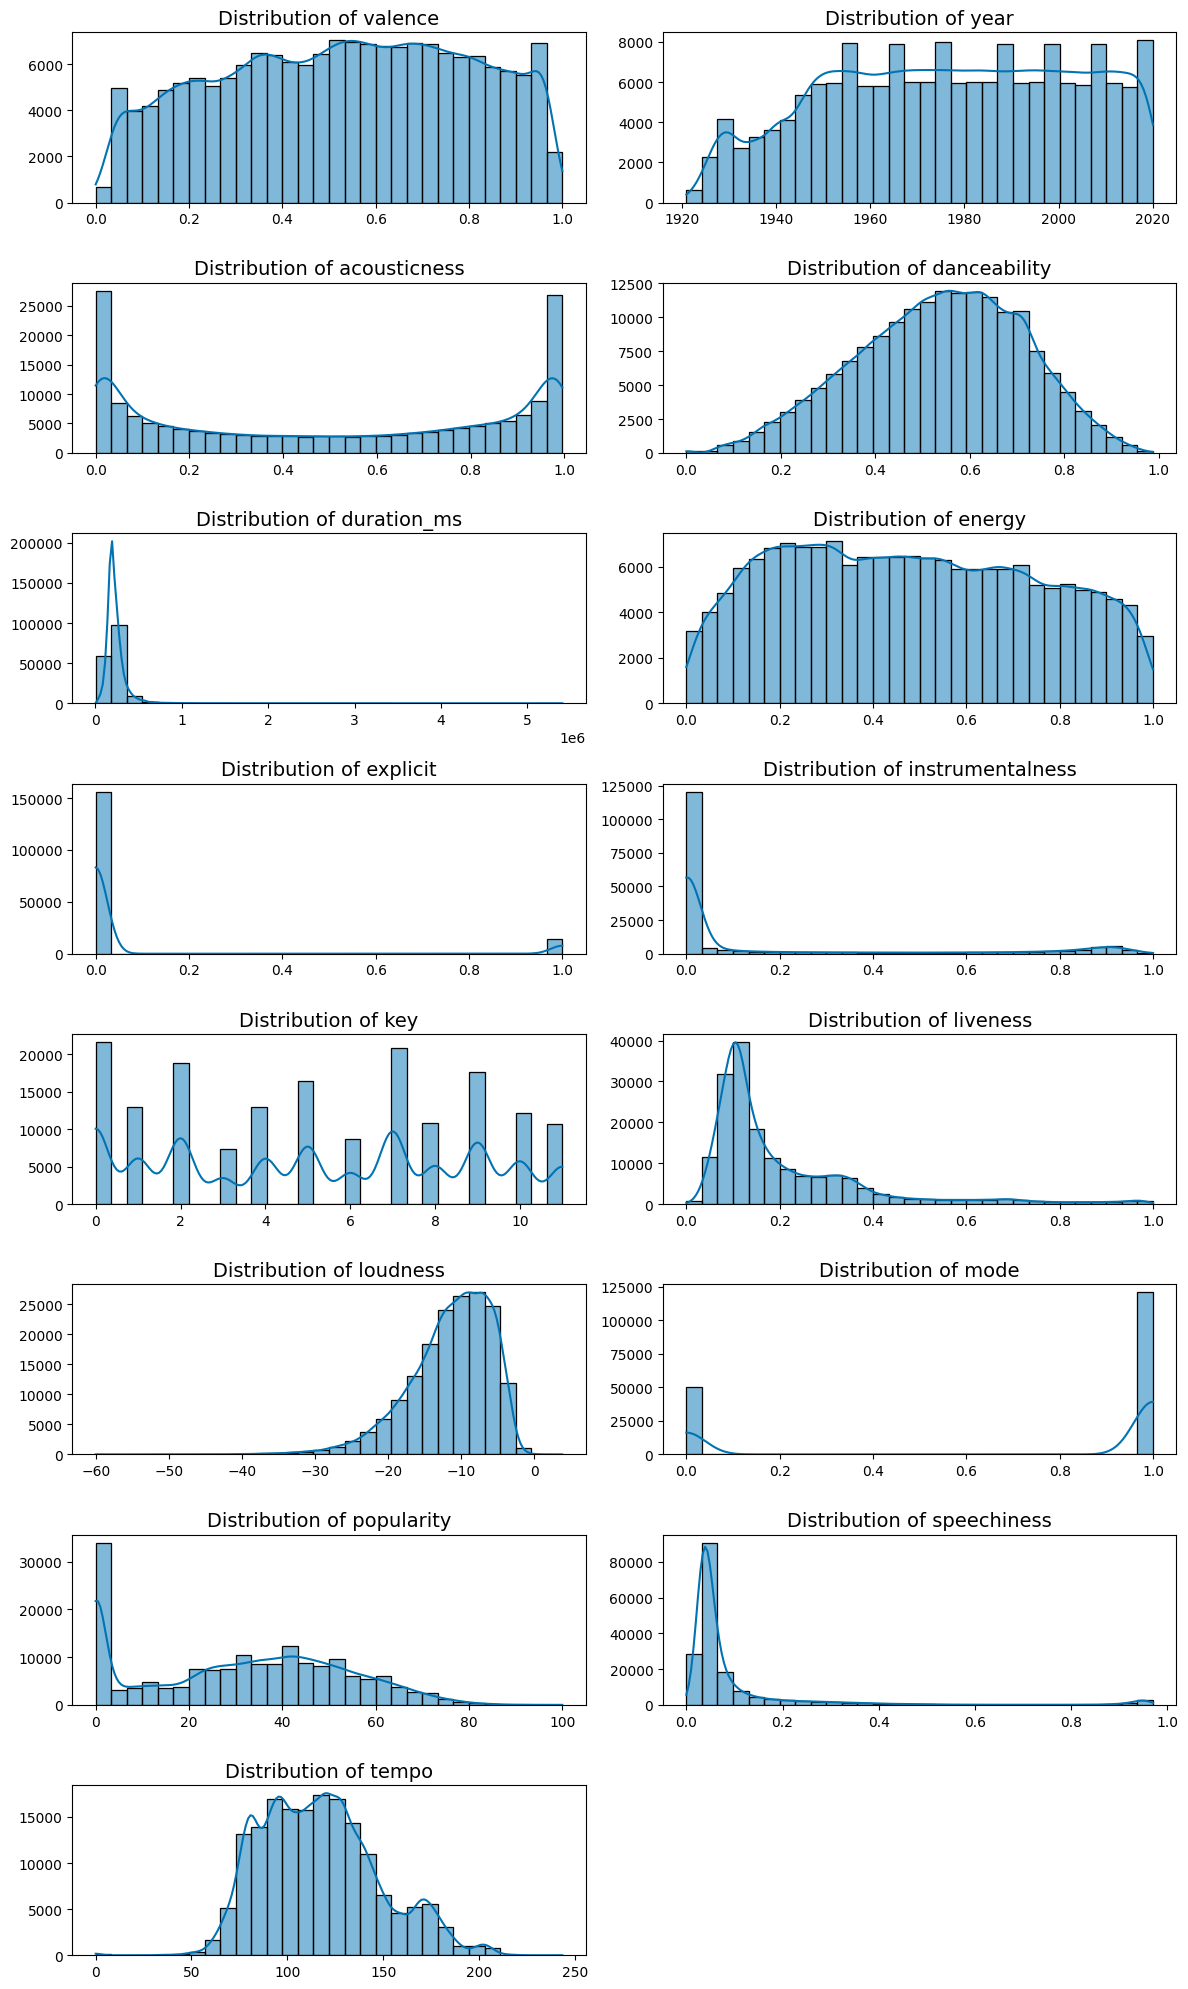

In [ ]:
# Visualizing the numerical columns
# Setting the aesthethic style of the plots
sns.set_palette("colorblind")

# Defining the numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calculating the number of rows needed for the visualization
num_rows = math.ceil(len(numerical_columns) / 2)

# Plotting the distributions of the numerical features
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 20))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Removing any extra empty subplots
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Most popular songs
most_popular_songs = data.nlargest(10, 'popularity')[['name', 'artists', 'popularity', 'year']]
most_popular_songs = most_popular_songs.reset_index(drop=True)
most_popular_songs

,name,artists,popularity,year
0,Dakiti,"['Bad Bunny', 'Jhay Cortez']",100,2020
1,Mood (feat. iann dior),"['24kGoldn', 'iann dior']",99,2020
2,Dynamite,['BTS'],97,2020
3,WAP (feat. Megan Thee Stallion),"['Cardi B', 'Megan Thee Stallion']",96,2020
4,positions,['Ariana Grande'],96,2020
5,What You Know Bout Love,['Pop Smoke'],96,2020
6,Blinding Lights,['The Weeknd'],96,2020
7,For The Night (feat. Lil Baby & DaBaby),"['Pop Smoke', 'Lil Baby', 'DaBaby']",95,2020
8,Holy (feat. Chance The Rapper),"['Justin Bieber', 'Chance the Rapper']",95,2020
9,Lonely (with benny blanco),"['Justin Bieber', 'benny blanco']",95,2020


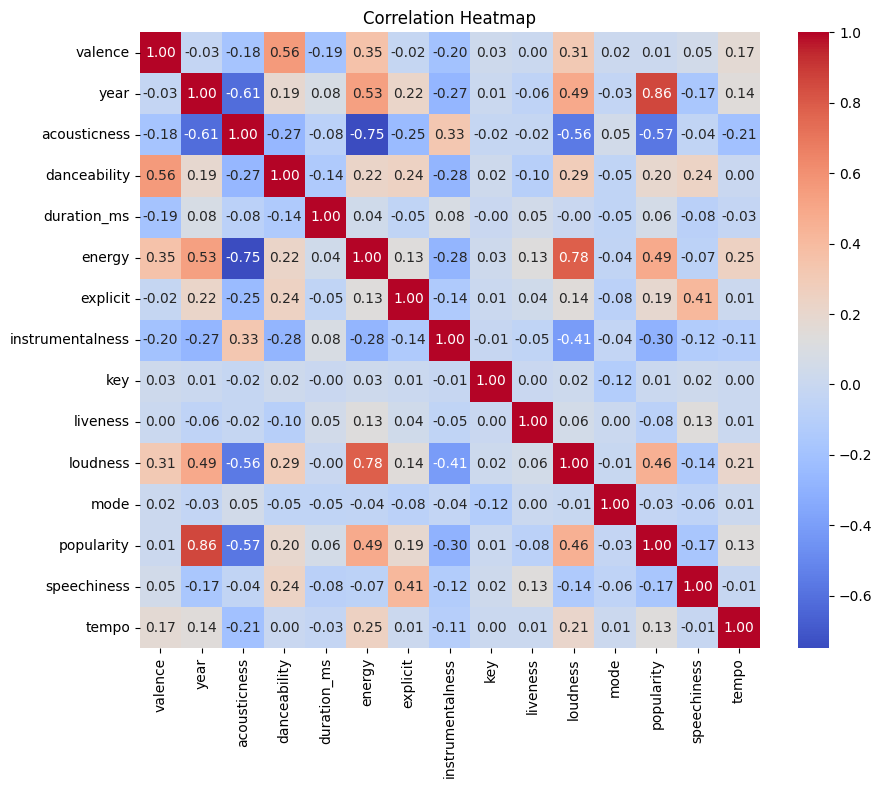

In [ ]:
# Correlation analysis
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Most popular artists
# Defining a function to evaluate strings as lists
def safe_literal_eval(node):
  try:
    return ast.literal_eval(node)
  except ValueError:
    return []

# Applying the funtion to convert the 'artists' string into a list creating a new column called "Artists_List"
data['artists_list'] = data['artists'].apply(safe_literal_eval)

# Exploding the 'artists_list so that each artist has their own row and keep track of their popularity
exploded_artists = data.explode('artists_list')
individual_artist_popularity = exploded_artists.groupby('artists_list')['popularity'].mean().sort_values(ascending=False).head(10).reset_index()

individual_artist_popularity.columns = ['artist', 'average_Popularity']
individual_artist_popularity

,artist,average_Popularity
0,Ritt Momney,93.0
1,Lele Pons,92.0
2,Los Legendarios,90.0
3,Jerry Di,89.0
4,Surf Mesa,88.0
5,salem ilese,88.0
6,Emilee,88.0
7,Towy,86.0
8,Nomcebo Zikode,86.0
9,Master KG,86.0


In [ ]:
# Top 5 most popular artists by decade
# Defining the new DataFrame with 'year', 'popularity' and 'artists' columns
decade_popularity = data[['year', 'popularity', 'artists']].copy()

# Function to map the year to its corresponding decade label
def map_year_to_decade(year):
    if 1920 <= year <= 1929:
        return '20s'
    elif 1930 <= year <= 1939:
        return '30s'
    elif 1940 <= year <= 1949:
        return '40s'
    elif 1950 <= year <= 1959:
        return '50s'
    elif 1960 <= year <= 1969:
        return '60s'
    elif 1970 <= year <= 1979:
        return '70s'
    elif 1980 <= year <= 1989:
        return '80s'
    elif 1990 <= year <= 1999:
        return '90s'
    elif 2000 <= year <= 2009:
        return '2000s'
    elif 2010 <= year <= 2020:
        return '2010s'
    else:
        return 'Unknown'

# Applying the function to map years to decades
decade_popularity['decade'] = decade_popularity['year'].apply(map_year_to_decade)

# Ensuring that 'artists' are evaluated from string representations of lists to actual lists
decade_popularity['artists_list'] = decade_popularity['artists'].apply(safe_literal_eval)

# Exploding the 'artists' column which contains lists of artists
decade_popularity_exploded = decade_popularity.explode('artists_list')

# Grouping by decade and artists, then calculating the average popularity
decade_artist_popularity = decade_popularity_exploded.groupby(['decade', 'artists_list'])['popularity'].mean().reset_index()

# Sorting the artists within each decade by their average popularity and then take the top 5 for each decade
top_artists_by_decade = decade_artist_popularity.sort_values(by=['decade', 'popularity'], ascending=[True, False])
top_5_artists_by_decade = top_artists_by_decade.groupby('decade').head(5).reset_index(drop=True)

top_5_artists_by_decade

,decade,artists_list,popularity
0,2000s,Band Aid,76.000000
1,2000s,Marta Sánchez,75.000000
2,2000s,Chris Rea,74.000000
3,2000s,Iyaz,74.000000
4,2000s,Judy Santos,74.000000
5,2010s,Ritt Momney,93.000000
6,2010s,Lele Pons,92.000000
7,2010s,Los Legendarios,90.000000
8,2010s,Jerry Di,89.000000
9,2010s,Emilee,88.000000


In [ ]:
# Checking the popularity of my favorite artists
# List of artists to check
artists_to_check = [
    "Don McLean", "The Rolling Stones", "Simon & Garfunkel", "Elvis Presley",
    "Billy Joel", "George Harrison", "Dolly Parton", "Lana Del Rey",
    "Katy Perry", "Sia", "David Guetta", "Maroon 5", "The Lumineers",
    "Imagine Dragons", "Nicki Minaj", "Adele", "Avicii", "OneRepublic",
    "Coldplay", "Taylor Swift", "Ella Fitzgerald", "Eric Clapton"
]

# Calculating average popularity for each artist
artist_popularity = {artist: exploded_artists[exploded_artists['artists_list'] == artist]['popularity'].mean()
                     for artist in artists_to_check}

# Converting dictionary to DataFrame
my_artist_popularity_df = pd.DataFrame(list(artist_popularity.items()), columns=['artist', 'average_popularity']).dropna().reset_index(drop=True)

my_artist_popularity_df

,artist,average_popularity
0,Don McLean,40.300000
1,The Rolling Stones,35.076923
2,Simon & Garfunkel,44.532710
3,Elvis Presley,33.998069
4,Billy Joel,40.705584
5,George Harrison,38.351648
6,Dolly Parton,35.099010
7,Lana Del Rey,58.104762
8,Katy Perry,61.770492
9,Sia,65.186047


In [ ]:
# Finding trends in music using statistics
# Creating a function to perform linear regression and return the slope (indicates trend) and p-value
def linear_trend_test(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, p_value

# Testing whether danceability increases over time
dance_slope, dance_p_value = linear_trend_test(data['year'], data['danceability'])

# Testing whether songs get shorter over time
duration_slope, duration_p_value = linear_trend_test(data['year'], data['duration_ms'])

# Testing whether songs become more diverse in keys over time
key_diversity_by_year = data.groupby('year')['key'].nunique()
key_diversity_slope, key_diversity_p_value = linear_trend_test(key_diversity_by_year.index, key_diversity_by_year)

# Testing whether liveness scores increase or decrease over time
live_slope, live_p_value = linear_trend_test(data['year'], data['liveness'])

# Testing whether songs get louder over time
loud_slope, loud_p_value = linear_trend_test(data['year'], data['loudness'])

# Testing whether speechiness decreases over time
speech_slope, speech_p_value = linear_trend_test(data['year'], data['speechiness'])

# Testing whether tempo increases over time
tempo_slope, tempo_p_value = linear_trend_test(data['year'], data['tempo'])

# Compiling results into a DataFrame
trend_tests_results = pd.DataFrame({
    'Feature': ['Danceability', 'Duration (Min)', 'Key Diversity', 'Liveness', 'Loudness', 'Speechiness', 'Tempo'],
    'Trend Slope': [dance_slope, duration_slope, key_diversity_slope, live_slope, loud_slope, speech_slope, tempo_slope],
    'P-Value': [dance_p_value, duration_p_value, key_diversity_p_value, live_p_value, loud_p_value, speech_p_value, tempo_p_value]
})

trend_tests_results

,Feature,Trend Slope,P-Value
0,Danceability,0.001281,0.000000e+00
1,Duration (Min),387.888587,1.486417e-238
2,Key Diversity,0.000000,1.000000e+00
3,Liveness,-0.000387,3.821202e-124
4,Loudness,0.107218,0.000000e+00
5,Speechiness,-0.001054,0.000000e+00
6,Tempo,0.167120,0.000000e+00


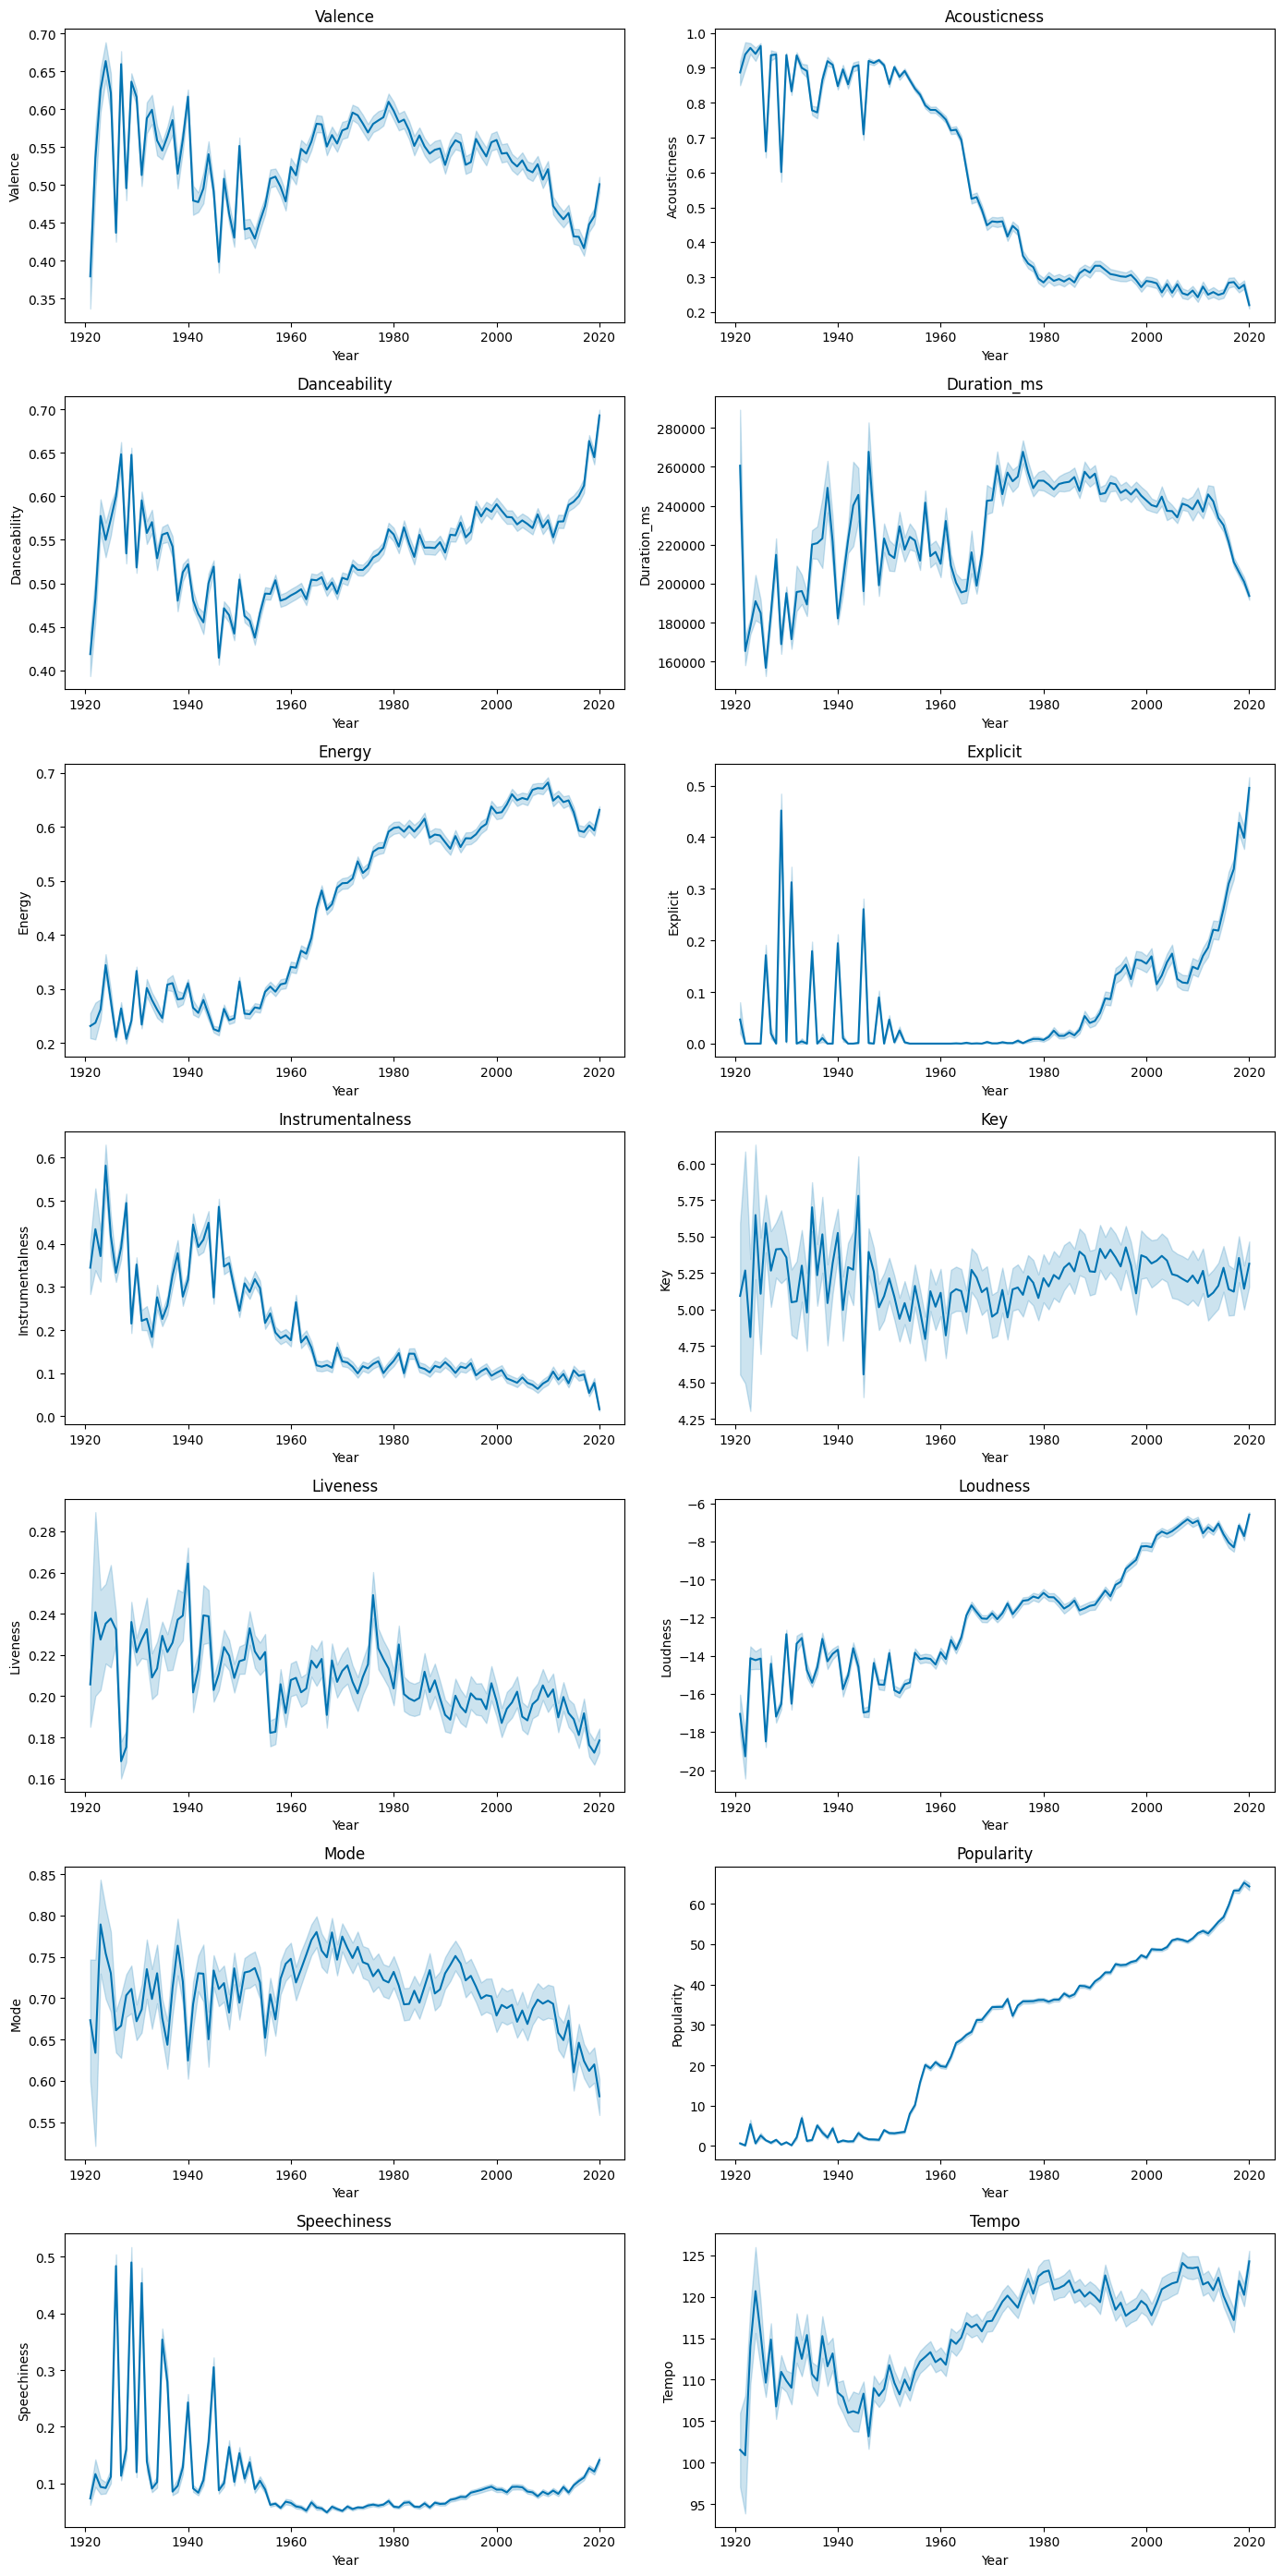

In [ ]:
# Visualizing the numerical columns by years
# Defining the columns to visualize
columns_to_visualize = [col for col in numerical_columns if col != 'year']

# Setting seaborn color palette to 'colorblind'
sns.set_palette('colorblind')

# Calculating the number of rows needed for subplots (2 columns per row)
num_rows = int(np.ceil(len(columns_to_visualize) / 2))

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
axes = axes.ravel()  # Flatten the axes array

# Plot each numerical feature by year on its subplot
for i, col in enumerate(columns_to_visualize):
    sns.lineplot(ax=axes[i], x='year', y=col, data=data)
    axes[i].set_title(f'{col.capitalize()}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(col.capitalize())

# If there is an odd number of columns, hide the last subplot
if len(columns_to_visualize) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Preparing the data for the recommendation system

I dropped columns I found irrelevant - 'id', 'artists'.

Also, to save immense data storage neeeds, I chose only the top half of songs by every decade. I chose this metric because over time songs recieve higher popularity from users. Old classics might fall behind the newest rap songs, disrupting the time distribution.

In [ ]:
# Dropping 'id' and 'artists'
data.drop(columns=['id', 'artists'], inplace=True)

In [ ]:
# Dropping bottom 50% least popular songs from each decade
# Grouping songs by their decade and calculating the median popularity
median_popularity_by_decade = data.groupby(data['year'] // 10 * 10)['popularity'].median()

# Dropping the bottom 50% of songs based on their popularity
bottom_50_percent = data['popularity'].quantile(0.5)
filtered_data = data[data['popularity'] > bottom_50_percent]

In [ ]:
# One-Hot Encoding the 'artists_list' column
# Initializing the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Applying the MultiLabelBinarizer
artists_encoded = mlb.fit_transform(filtered_data['artists_list'].tolist())
artists_encoded_df = pd.DataFrame(artists_encoded, columns=mlb.classes_, index=filtered_data.index)

In [ ]:
# Normalizing the data
# Initializing a scaler to normalize the data in a range between 0 and 1
scaler = MinMaxScaler()

# Defining the columns to normalize
columns_to_normalize = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

# Applying normnalization
filtered_data[columns_to_normalize] = scaler.fit_transform(filtered_data[columns_to_normalize])

<ipython-input-22-038a0f0f32f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[columns_to_normalize] = scaler.fit_transform(filtered_data[columns_to_normalize])


In [ ]:
# Combining normalized data with encoded artist information
recommendation_data = pd.concat([filtered_data[columns_to_normalize].reset_index(drop=True), artists_encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
# Recommendation function that dynamically computes similarity
def recommend_songs_dynamic(song_name, artist_name, data, recommendation_data, top_n=5):
    song_row = data[(data['name'].str.lower() == song_name.lower()) &
                    (data['artists_list'].apply(lambda x: artist_name.lower() in [a.lower() for a in x]))]

    if song_row.empty:
        return f"Song '{song_name}' by '{artist_name}' not found."

    # Get the index in the original DataFrame to match in recommendation_data
    song_index = song_row.index.values[0]
    song_features = recommendation_data.iloc[[song_index]]

    # Compute cosine similarity for this song against all others
    similarity_scores = cosine_similarity(recommendation_data, song_features).flatten()

    # Get top N similar song indices
    similar_indices = similarity_scores.argsort()[-top_n-1:-1][::-1][1:]  # Skip the first one (itself)

    # Get the song names
    similar_songs = data.iloc[similar_indices]['name'].tolist()

    return similar_songs

# Making recommendations

In [ ]:
aint_no_rest_for_the_wicked_recommendations = recommend_songs_dynamic("Summertime", "Ella Fitzgerald", filtered_data, recommendation_data, top_n=5)
iris_recommendations = recommend_songs_dynamic("Iris", "The Goo Goo Dolls", filtered_data, recommendation_data, top_n=5)
eleanor_rigby_recommendations = recommend_songs_dynamic("Cardigan", "Taylor Swift", filtered_data, recommendation_data, top_n=5)

print("Recommendations for 'Ain't No Rest For The Wicked' by Cage The Elephant:", aint_no_rest_for_the_wicked_recommendations)
print("Recommendations for 'Iris' by The Goo Goo Dolls:", iris_recommendations)
print("Recommendations for 'Eleanor Rigby' by Bon Jovi:", eleanor_rigby_recommendations)

Recommendations for 'Ain't No Rest For The Wicked' by Cage The Elephant: ['People Got to Be Free', 'Mi Último Deseo', 'La Bala', 'Harder To Breathe - Acoustic']
Recommendations for 'Iris' by The Goo Goo Dolls: ['It Came Out Of The Sky', 'Up Around The Bend - Live In Amsterdam 9-10-71', 'Commotion', 'Green River']
Recommendations for 'Eleanor Rigby' by Bon Jovi: ['Fascination Street - 2010 Remaster', 'Out of This World', 'Open', 'Lovesong - 2010 Remaster']
